In [ ]:
!pip install -r requirements.txt
!git clone https://github.com/drewjenks01/streaming-llm-rag.git
%cd streaming-llm-rag
!python setup.py develop

In [1]:
from streaming_llm.utils import load
from streaming_llm.enable_streaming_llm import enable_streaming_llm
import torch
import os
import numpy as np
import json
from sentence_transformers import SentenceTransformer, util

/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change to number of devices
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [4]:
@torch.no_grad()
def greedy_generate(model, tokenizer, input_ids, past_key_values, max_gen_len):
    outputs = model(
        input_ids=input_ids,
        past_key_values=past_key_values,
        use_cache=True,
    )
    past_key_values = outputs.past_key_values
    pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
    generated_ids = [pred_token_idx.item()]
    pos = 0
    for _ in range(max_gen_len - 1):
        outputs = model(
            input_ids=pred_token_idx,
            past_key_values=past_key_values,
            use_cache=True,
        )
        past_key_values = outputs.past_key_values
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
        generated_ids.append(pred_token_idx.item())
        generated_text = (
            tokenizer.decode(
                generated_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
                spaces_between_special_tokens=False,
            )
            .strip()
            .split(" ")
        )

        now = len(generated_text) - 1
        if now > pos:
            print(" ".join(generated_text[pos:now]), end=" ", flush=True)
            pos = now

        if pred_token_idx == tokenizer.eos_token_id:
            break
        
    print(" ".join(generated_text[pos:]), flush=True)
    return past_key_values, ' '.join(generated_text)

@torch.no_grad()
def streaming_inference(model, tokenizer, prompts, kv_cache=None, max_gen_len=50, rag=None):
    past_key_values = None
    for idx, prompt in enumerate(prompts):
        # the question will be the third prompt, which we want to use rag for 
        if idx==2:
            if rag is not None:
                rag_prompt = rag(prompt)
                if rag_prompt is not None:
                    prompt += rag_prompt

            # add inst ending either way
            prompt += "[/INST]"

        prompt = "USER: " + prompt + "\n\nASSISTANT: "
        print("\n" + prompt, end="")
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids

            
        input_ids = input_ids.to(model.device)
        seq_len = input_ids.shape[1]
        if kv_cache is not None:
            space_needed = seq_len + max_gen_len
            # if past_key_values is not None:
            #     print(past_key_values[0][0].shape, space_needed)
            past_key_values = kv_cache.evict_for_space(past_key_values, space_needed)


        past_key_values, response = greedy_generate(
            model, tokenizer, input_ids, past_key_values, max_gen_len=max_gen_len
        )
    return response

In [5]:
class RAG:
    def __init__(self, model):
        self.embed_storage = {'sentences':[], 'embeds':[]}
        self.model = model

    def __call__(self, question_str):

        question_str = question_str.split(':')[1]

        # tokenize and embed question
        question_embed = self.model.encode(question_str)

        # get cosine similarity between padded input ids and stored tokens
        cos_sim = util.cos_sim(question_embed, self.embed_storage['embeds'])[0]

        # get the top sentence
        top_matches = torch.topk(cos_sim, k=1)

        sentences = ','.join([self.embed_storage['sentences'][indx] for indx in top_matches[1]])
        
        prompt = self.make_rag_prompt(sentences)
        return prompt

    def make_rag_prompt(self, most_similar_text):
        if most_similar_text is not None:
            rag_prompt = f" The following retreived information may or may not be helpful for your answer: \"{most_similar_text}\""
            prompt = rag_prompt

        else:
            prompt = ""
        return prompt

    
    def store(self, story):
        # split story into setences
        story = story.split('.')

        #tokenize sentences
        embeds = self.model.encode(story)

        for sentence, embed in zip(story, embeds):
            self.embed_storage['sentences'].append(sentence)
            self.embed_storage['embeds'].append(embed)

In [6]:
def load_jsonl(
    file_path,
):
    list_data_dict = []
    with open(file_path, "r") as f:
        for line in f:
            list_data_dict.append(json.loads(line))
    return list_data_dict

In [7]:
model, tokenizer = load('mistralai/Mistral-7B-Instruct-v0.1')
sentence_tranformer = SentenceTransformer('msmarco-MiniLM-L-6-v3')

# collect stories from json file
list_data = load_jsonl('Single-Turn-QA-pairs.jsonl')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model from mistralai/Mistral-7B-Instruct-v0.1 ...


Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


In [8]:

def check_answer(guess, answer_key_words):
    guess = guess.lower()
    key_words_lower = [word.lower() for word in answer_key_words.split()]
    for word in key_words_lower:
        if word.lower() in guess:
            continue
        else:
            return False 
    return True
    

def make_prompts(rag, story, question):
    init_prompt =  "<s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>"
    story_prompt = "[INST] Here's the story:\n\n"+story+"[/INST]"
    # [/INST] not added yet in case rag prompt used
    question_prompt = "[INST] Answer this question using a quote from the above story: "+ question

    if rag is not None:
        # store story for rag
        rag.store(story)

    return init_prompt, story_prompt, question_prompt


def check_story_question(prompts, answer_key_words, use_rag):
    kv_cache = enable_streaming_llm(
            model, start_size=4, recent_size=250
        )
    if use_rag:
        rag = RAG(sentence_tranformer)
    else:
        rag = None

    prompts = make_prompts(rag, prompts[0], prompts[1])
    model_response = streaming_inference(
        model,
        tokenizer,
        prompts,
        kv_cache,
        rag=rag
    )
    return check_answer(model_response, answer_key_words)

        

In [9]:
scores ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = True

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores[location][0]+=1
    else:
        print("Incorrect!")
    scores[location][1]+=1

    print('----------------------------')

percentages = {key: scores[key][0]/scores[key][1] if scores[key][1]>0 else 'N/A' for key in scores}
print('Final scores:', percentages)

StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again." Max was so happy that he could play with his friends without pain. He learned that sometimes, it was good to slow down and listen to 

/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/sentence_transformers/util.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  b = torch.tensor(b)


a dog. The quote from the story says "Once upon a time, there was a clever little dog named Max".
Correct!
----------------------------
StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again

In [10]:
scores_without_rag ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = False

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores_without_rag[location][0]+=1
    else:
        print("Incorrect!")
    scores_without_rag[location][1]+=1

    print('----------------------------')

percentages_without_rag = {key: scores_without_rag[key][0]/scores_without_rag[key][1] if scores_without_rag[key][1]>0 else 'N/A' for key in scores_without_rag}
print('Final scores:', percentages_without_rag)

StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again." Max was so happy that he could play with his friends without pain. He learned that sometimes, it was good to slow down and listen to 

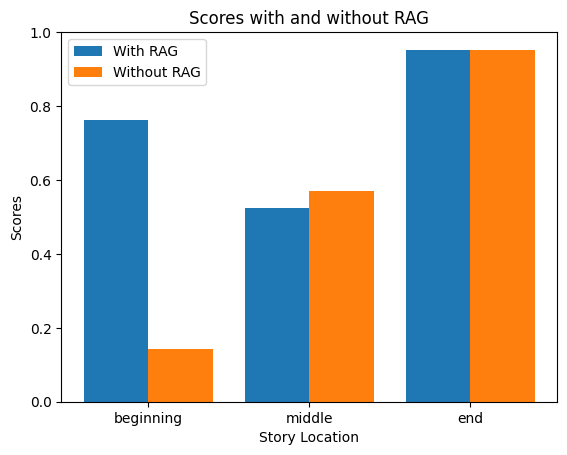

In [11]:
import matplotlib.pyplot as plt

# Scores with RAG
scores_with_rag = percentages
# Scores without RAG
scores_without_rag = percentages_without_rag

# Locations
locations = ['beginning', 'middle', 'end']

# Bar positions
bar_positions = range(len(locations))

# Bar heights
bar_heights_with_rag = [scores_with_rag[loc] for loc in locations]
bar_heights_without_rag = [scores_without_rag[loc] for loc in locations]

# Bar labels
bar_labels = ['With RAG', 'Without RAG']

# Plotting the bar chart
plt.bar(bar_positions, bar_heights_with_rag, width=0.4, label='With RAG')
plt.bar([p + 0.4 for p in bar_positions], bar_heights_without_rag, width=0.4, label='Without RAG')

# Adding labels and title
plt.xlabel('Story Location')
plt.ylabel('Scores')
plt.title('Scores with and without RAG')
plt.xticks([p + 0.2 for p in bar_positions], locations)
plt.legend()

# Displaying the chart
plt.show()

